# CNN & More

## Easy, but Important!

---

### 라이브러리 로딩

In [1]:
'''
라이브러리들을 불러오자.
'''
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


id = 5651
다음 그림은 숫자 1 입니다.


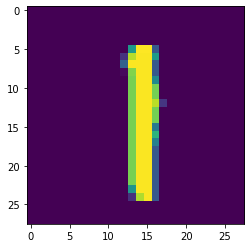

In [6]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id])
plt.show()

### Convolutional Layer를 위한 reshape!

* One-Hot Encoding

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
len(np.unique(train_y))

10

In [9]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [10]:
train_y.shape

(60000, 10)

In [11]:
# x : 흑백을 명시하기 위한 reshape
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


* 이미지 값을 0 ~ 1 사이 값을 갖도록 스케일 조정!

In [12]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 255   min : 0


In [13]:
# min-max scaling
train_x = train_x/255
test_x = test_x/255



In [14]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 1.0   min : 0.0


### Sequential API 모델링

CNN에 관한 것만 추가가 된다.
[여기](https://keras.io/layers/convolutional/)를 적극적으로 참고하자

In [15]:
# 혹시 이미 그려둔 그래프가 있다면 날려줘!
clear_session()

# model에 순차적으로 레이어를 쌓아가겠다는 의도!
model = keras.models.Sequential()

model.add( Input(shape=(28,28,1)) )
model.add( Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu') )
model.add( Conv2D(filters=32,
                  kernel_size=(3,3),
                  activation='relu') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.20) )

model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.25) )

model.add( Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Dropout(0.25) )

model.add( Flatten() )
model.add( Dense(128, activation = 'relu') )
model.add( BatchNormalization()  )
model.add( Dropout(0.25) )
model.add( Dense(10, activation = 'softmax') )

# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

In [16]:
# 모델 컴파일

model.compile(loss = keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer = 'adam')

### **Data Augmentation**

In [17]:
datagen = ImageDataGenerator(
    rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

### Real-time data augmentation 을 위하여!

* validation set을 따로 만들어 두자.

In [18]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=2023)

* Early Stopping 적용

In [19]:
es = EarlyStopping(monitor='val_loss', # 개선 대상
                   min_delta=0,        # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=5,         # 개선없는 epoch를 얼마나 기다려줄거야?
                   verbose=1,
                   restore_best_weights=True)

* 모델 체크포인트

In [20]:
mcp = ModelCheckpoint(filepath='/content/model_save.h5',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False) # 가중치만 저장 or 모델 구조도 저장

* training

In [21]:
# 데이터를 넣어서 학습시키자!
datagen.fit(train_x)

history = model.fit(datagen.flow(train_x, train_y, batch_size=1024),
                    epochs=10000, validation_data=(val_x, val_y),
                    verbose=1, callbacks=[es, mcp])

Epoch 1/10000
53/53 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7836
Epoch 1: val_loss improved from inf to 1.30611, saving model to /content/model_save.h5
53/53 [==============================] - 28s 322ms/step - loss: 0.6632 - accuracy: 0.7836 - val_loss: 1.3061 - val_accuracy: 0.8623
Epoch 2/10000
53/53 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9582
Epoch 2: val_loss improved from 1.30611 to 0.91990, saving model to /content/model_save.h5
53/53 [==============================] - 17s 314ms/step - loss: 0.1414 - accuracy: 0.9582 - val_loss: 0.9199 - val_accuracy: 0.9838
Epoch 3/10000
53/53 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9716
Epoch 3: val_loss improved from 0.91990 to 0.54501, saving model to /content/model_save.h5
53/53 [==============================] - 16s 308ms/step - loss: 0.0926 - accuracy: 0.9716 - val_loss: 0.5450 - val_accuracy: 0.9822
Epoch 4/10000
53/53 [=======================

In [22]:
performance_test = model.evaluate(test_x, test_y, batch_size=1024)

print('Test Loss : {:.6f},  Test Accuracy : {:.3f}%'.format(performance_test[0], performance_test[1]*100))

10/10 [==============================] - 1s 51ms/step - loss: 0.0125 - accuracy: 0.9964
Test Loss : 0.012510,  Test Accuracy : 99.640%


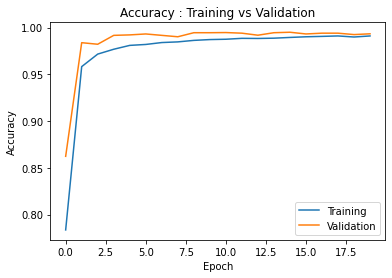

In [23]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

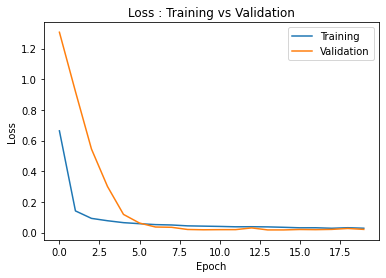

In [24]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## Model Save & Load

In [25]:
model.save('my_first_save.h5')

In [29]:
clear_session()

In [30]:
# model = keras.models.load_model('my_first_save.h5')
model = keras.models.load_model('model_save.h5')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

In [31]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

313/313 [==============================] - 1s 2ms/step
CNN
트레이닝 정확도 : 99.64%
테스트 정확도 : 99.64%


id = 5049
다음 그림은 숫자 8 입니다.
모델의 예측 : 8
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0. 99.  0.]
정답입니다


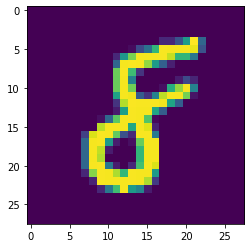

In [33]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

id = 2447
다음 그림은 숫자 4 입니다.
모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 28.  0.  0.  0.  0. 71.]
틀렸어요


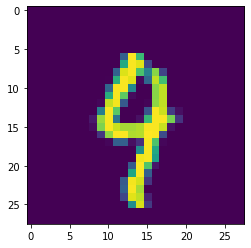

In [34]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

In [ ]:
model.summary()

In [ ]:
model.save()

# 내가 쓴 숫자도 인식할까?

### 내 그림 파일을 업로드 해둔 곳으로 가자!

## 구글 드라이브에 내가 그림판에서 쓴 숫자 그림파일을 업로드해두자!
## 그리고 그 경로로 찾아들어가자!

**경로에 대하여**
1. my_data폴더를 구글드라이브에 바로 만들어둔다.
2. my_data폴더 안에 my_mnist폴더를 만든다.
3. 이미지를 그림판으로 제작하고, my_mnist라는 폴더안에 업로드한다.
4. 5초 정도 여유를 갖자.
5. 아래 코드들을 실행한다

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
ls

drive/  model_save.h5  my_first_save.h5  sample_data/


In [50]:
cd /content/drive/MyDrive/에이블스쿨/실습파일/2023.03.13.CNN_2.0ver/2_Data_augmentation_and_more

/content/drive/MyDrive/에이블스쿨/실습파일/2023.03.13.CNN_2.0ver/2_Data_augmentation_and_more


In [51]:
ls

2_01_Data_Augmentation_basics.ipynb
2_02_Data_Augmentation_notMNIST_2.0ver.ipynb
2_03_exercise_Data_Augmentation_2.0ver.ipynb
2_04_MyData_Save_Load_2.0ver.ipynb
2_05_pretrained_CNN_2.0ver.ipynb
2_06_Transfer_Learning_2.0ver.ipynb
handmade_num/


### 이미지를 불러와보자

In [49]:
import glob
from tensorflow.keras.preprocessing import image

In [52]:
files = glob.glob('handmade_num/*')

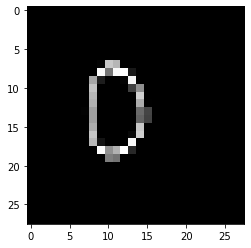

In [54]:
img = image.load_img(files[0], color_mode='grayscale', target_size = (28,28) )
img = image.img_to_array(img)
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [55]:
img = 255-img

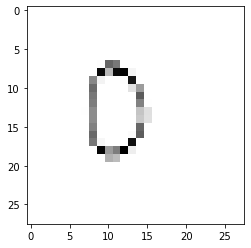

In [56]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [57]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 [==============================] - 0s 120ms/step


2

### 이미지가 여러 장이라면

In [66]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size = (28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img / 255)

images = np.array(images)

1/1 [==============================] - 0s 34ms/step
모델의 예측 : 9
모델의 카테고리별 확률 : [18.  0.  1.  0.  0.  2.  0.  0.  3. 69.]


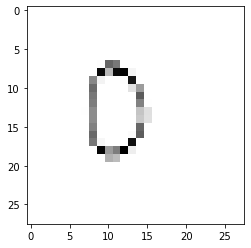

모델의 예측 : 1
모델의 카테고리별 확률 : [ 0. 99.  0.  0.  0.  0.  0.  0.  0.  0.]


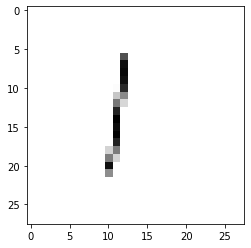

모델의 예측 : 1
모델의 카테고리별 확률 : [ 0. 97.  2.  0.  0.  0.  0.  0.  0.  0.]


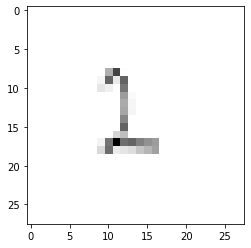

모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  2.  1. 92.  0.  2.  0.  0.  0.  0.]


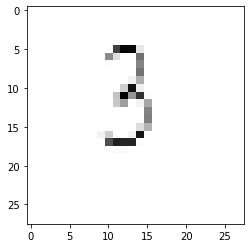

모델의 예측 : 4
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 97.  0.  0.  0.  0.  2.]


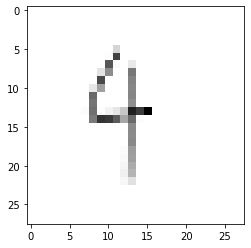

모델의 예측 : 5
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0. 99.  0.  0.  0.  0.]


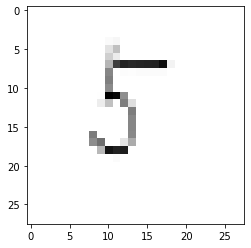

모델의 예측 : 6
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  2. 93.  0.  2.  0.]


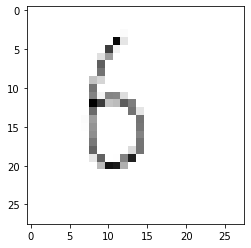

모델의 예측 : 7
모델의 카테고리별 확률 : [ 0. 23.  0.  0.  0.  0.  0. 71.  0.  4.]


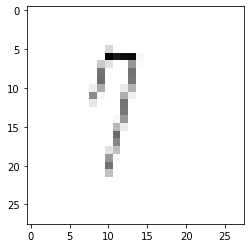

모델의 예측 : 8
모델의 카테고리별 확률 : [ 0.  0.  1.  0.  0.  0.  0.  0. 89.  8.]


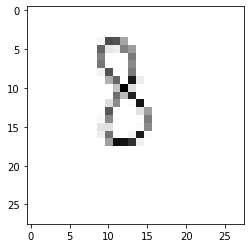

모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 99.]


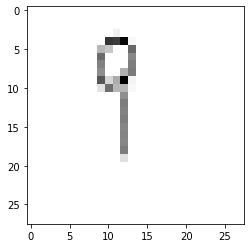

In [67]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')
    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

-----------------

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
idg = ImageDataGenerator(rescale=1./255, 
                         rotation_range=25, 
                         shear_range=0.1, 
                         zoom_range=0.1,
                         width_shift_range=0.1, 
                         height_shift_range=0.1)

In [73]:
hand_made_flow = idg.flow_from_directory('handmade_num', 
                        target_size=(28, 28), 
                        color_mode='grayscale',
                        save_to_dir='/content/temp/',
                        save_prefix='temp',
                        save_format='png')

Found 10 images belonging to 10 classes.


In [81]:
model.fit(hand_made_flow, epochs=1)

1/1 [==============================] - 0s 41ms/step - loss: 0.4624 - accuracy: 0.8000


In [83]:
img, label = hand_made_flow.next()
label

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)